In [1]:
import os
import gym
import numpy as np
import torch
from tqdm import tqdm
from CustomGymEnvs import MujocoGraphNormalWrapper, FetchReachGraphWrapper
from pathlib import Path
from Graph_SAC.sac import SAC
from utils import state_2_graphbatch, load_object
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style


In [2]:
env_name = 'HalfCheetah-v2'
# env_name = 'Walker2d-v2'
# env_name = 'Hopper-v2'
# env_name = 'FetchReach-v2'

In [3]:
root_path = os.path.join(Path(os.getcwd()), 'Data', env_name) 
exp_path = os.path.join(root_path, 'graph')
obj_path = os.path.join(exp_path, 'edge_relevance.pkl')
edge_relevance = load_object(obj_path)

global_relevance = None
if env_name == 'FetchReach-v2':
    obj_path = os.path.join(exp_path, 'global_relevance.pkl')
    global_relevance = load_object(obj_path)
    edge_relevance = np.delete(edge_relevance, 7, axis=0)
    edge_relevance = np.delete(edge_relevance, 7, axis=0)

In [4]:
# Environment
if 'FetchReach' in env_name:
    env = FetchReachGraphWrapper(gym.make(env_name))
else:
    env = MujocoGraphNormalWrapper(env_name)

edge_list = env.robot_graph.edge_list
node_list = env.robot_graph.node_list

In [5]:
def process_joint_name(joint_name):
    separated = joint_name.split(':')[1].split('_') if 'robot0' in joint_name else joint_name.split('_')
    final_key = ''
    for sk in separated:
        if len(sk) == 1:
            final_key += sk + '-'
        else:
            final_key += sk + ' '
    return final_key.strip()

entity_names = []
for joint_list in edge_list.values():
    if len(joint_list) > 0:
        if len(joint_list) == 1:
            joint_label = process_joint_name(joint_list[0].attrib['name'])
        elif len(joint_list) > 1 and 'root' in joint_list[0].attrib['name']:
            joint_label = 'torso'
        else:
            joint_label = '\n'.join([process_joint_name(j.attrib['name']) for j in joint_list])
        entity_names.append(joint_label)

if env_name == 'FetchReach-v2':
    entity_names = ['goal'] + entity_names
    entity_names.remove('l-gripper finger joint')
    entity_names.remove('r-gripper finger joint')

entity_names = [j if 'joint' not in j else j.split('joint')[0].strip() for j in entity_names]

action_labels = [j for j in entity_names if j not in ['torso', 'goal']]


In [6]:
def plot_joint_action_heatmap(data, width, height):
    plt.rcParams.update({'font.size': 20})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(width, height), gridspec_kw={'width_ratios': (30, 1)})
    sns.heatmap(data, ax=ax1, cbar=False, 
                cmap="cividis", 
                linewidth=1, 
                vmin=np.min(data), 
                vmax=np.max(data),
                annot=True,
                fmt='.2f')
    ax1.set_xticks(np.arange(len(entity_names)) + 0.5, labels=[j for j in entity_names], rotation=45, fontsize=20)
    ax1.set_yticks(np.arange(len(action_labels)) + 0.5, labels=action_labels, rotation=45, fontsize=20)
    ax1.set_title(f"Avg action-joint relevance score - {env_name}", fontsize=20, pad=40)
    ax1.set_ylabel("Actions (Torques applied to each joint)", fontsize=20)
    ax1.set_xlabel(f"Joint name", fontsize=20)

    plt.colorbar(plt.cm.ScalarMappable(cmap="cividis", norm=plt.Normalize(vmin=np.min(data), vmax=np.max(data))), cax=ax2)
    ax2.yaxis.set_ticks_position('left')
    ax2.set_ylabel('Avg relevance score across seeds', fontsize=20)
    fig.tight_layout()
    fig.savefig(os.path.join(root_path, 'LRP_result.jpg'), dpi=300)
    plt.show()

In [14]:
avg_edge_rel = edge_relevance.sum(axis=4).sum(axis=3).sum(axis=2)

if global_relevance is not None:
    avg_global_rel = global_relevance.sum(axis=3).sum(axis=2).sum(axis=1)
    avg_edge_rel = np.concatenate((avg_global_rel[np.newaxis, :], avg_edge_rel))
    
# -------------- Normalization ---------------------
avg_edge_rel /= np.max(np.abs(avg_edge_rel), axis=0)


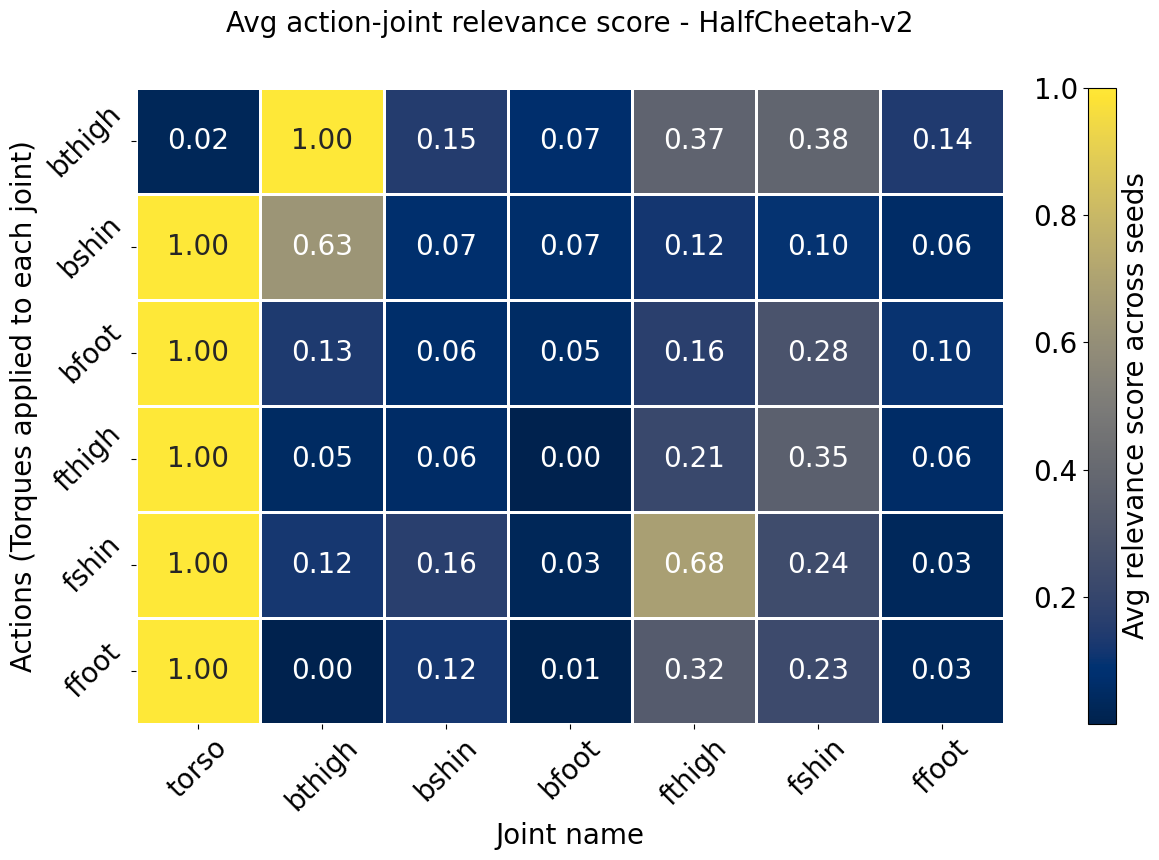

In [15]:
figure_width = 12
figure_height = 9

plot_joint_action_heatmap(np.abs(avg_edge_rel.T),
                          figure_width,
                          figure_height)

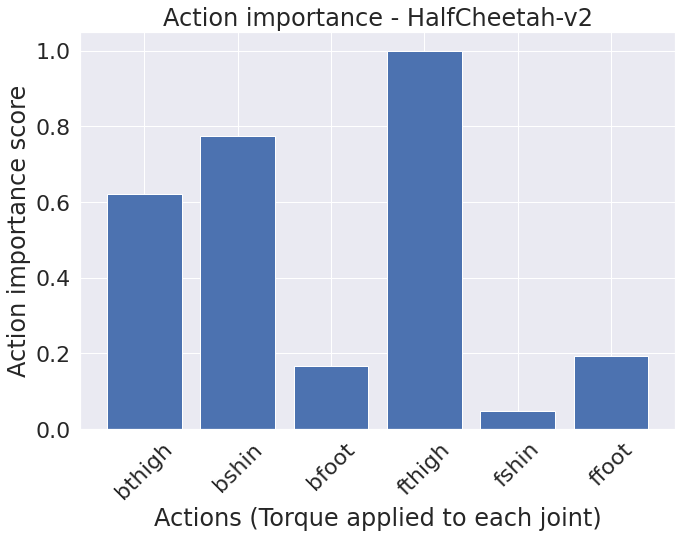

In [9]:
# action_rel = np.abs(avg_edge_rel.sum(axis=0)) # half-cheetah, walker-2d
# action_rel = avg_edge_rel.mean(axis=0)
# action_rel = np.abs(avg_edge_rel).mean(axis=0) 

action_rel = edge_relevance.sum(axis=4).sum(axis=3).sum(axis=2).sum(axis=0) #FetchReach-v2, walker2d, halfcheetah(kinda)
if global_relevance is not None:
    action_rel += global_relevance.sum(axis=3).sum(axis=2).sum(axis=1)

action_rel = np.abs(action_rel)

action_rel /= np.max(action_rel)

sns.set_theme()
sns.set(font_scale=2)
plt.figure(figsize=(10,8))
plt.bar(action_labels, action_rel)
# plt.bar(action_labels, action_rel)
plt.xlabel('Actions (Torque applied to each joint)')
plt.ylabel('Action importance score')
plt.xticks(rotation=45)
plt.title(f'Action importance - {env_name}')
plt.tight_layout()
# plt.savefig(os.path.join(exp_path, 'action_importance.jpg'), dpi=300)
sns.reset_orig()
plt.show()

## Joint Relevance

The relevance of action to each joint should be multiplied by the weight of that action to be true

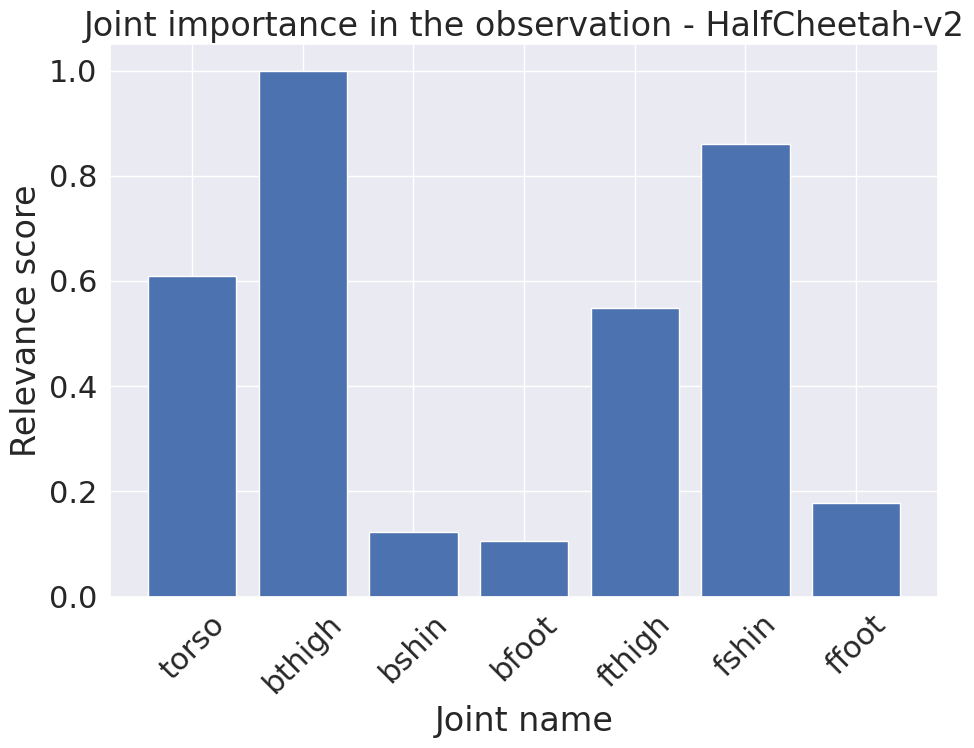

In [17]:
# --------------- First method for calculating importance (without considering action importance)-----------
# walker2d, FetchReach-v2
# joint_importance = np.abs(avg_edge_rel.mean(axis=1))
# joint_importance /= np.max(joint_importance)

joint_importance = np.abs(avg_edge_rel.var(axis=1))
joint_importance /= np.max(joint_importance)


# --------------- Second Method -----------------------------
# walker2d
# joint_importance = np.abs(edge_relevance).sum(axis=4).sum(axis=3).sum(axis=2).sum(axis=1)
# if global_relevance is not None:
#     joint_importance = np.concatenate([[np.abs(global_relevance.sum())], joint_importance])

# joint_importance /= np.max(joint_importance)


#---------------- Third Method for calculating joint importance -----------------
# half-cheetah, walker2d
# joint_importance = np.abs(action_rel.dot(avg_edge_rel.T))
# joint_importance /= np.max(joint_importance)

# --------------- Forth Method -----------------------------
# walker2d
# joint_importance = edge_relevance.std(axis=4).mean(axis=3).mean(axis=2).mean(axis=1)
# if global_relevance is not None:
#     global_importance = global_relevance.var(axis=3).mean()
#     joint_importance = np.concatenate([[global_importance], joint_importance])

# joint_importance /= np.max(joint_importance)


sns.set_theme()
sns.set(font_scale=2)
plt.figure(figsize=(10,8))
plt.bar(entity_names, joint_importance)
plt.xlabel('Joint name')
plt.ylabel('Relevance score')
plt.xticks(rotation=45)
plt.title(f'Joint importance in the observation - {env_name}')
plt.tight_layout()
# plt.savefig(os.path.join(exp_path, 'joint_importance.jpg'), dpi=300)
sns.reset_orig()
plt.show()

In [11]:
joint_importance_pos = edge_relevance.clip(min=0).sum(axis=4).sum(axis=3).sum(axis=2).sum(axis=1)
joint_importance_neg = edge_relevance.clip(max=0).sum(axis=4).sum(axis=3).sum(axis=2).sum(axis=1)

global_importance_pos = global_relevance.clip(min=0).sum()
global_importance_neg = global_relevance.clip(max=0).sum()

joint_importance_pos = np.concatenate([[global_importance_pos], joint_importance_pos])
joint_importance_neg = np.concatenate([[global_importance_neg], joint_importance_neg])


AttributeError: 'NoneType' object has no attribute 'clip'

In [ ]:
sns.set_theme()
sns.set(font_scale=2)
plt.figure(figsize=(10,8))

ind = np.arange(len(entity_names)) 
width = 0.25

plt.bar(ind, joint_importance_pos, width, label='Positive')
plt.bar(ind + width, joint_importance_neg, width, label='Negative')
plt.bar(ind + width * 2, joint_importance_pos + joint_importance_neg, width, label='Diff')

plt.xlabel('Joint name')
plt.ylabel('Relevance score')
plt.xticks(ind + width, entity_names, rotation=45)
plt.title(f'Joint importance in the observation - {env_name}')
plt.legend()
plt.tight_layout()
# plt.savefig(os.path.join(exp_path, 'joint_importance.jpg'), dpi=300)
sns.reset_orig()
plt.show()

In [ ]:
action_rel_pos = edge_relevance.clip(min=0).sum(axis=4).sum(axis=3).sum(axis=2).sum(axis=0)
action_rel_neg = edge_relevance.clip(max=0).sum(axis=4).sum(axis=3).sum(axis=2).sum(axis=0)

if global_relevance is not None:
    action_rel_pos += global_relevance.clip(min=0).sum(axis=3).sum(axis=2).sum(axis=1)
    action_rel_neg += global_relevance.clip(max=0).sum(axis=3).sum(axis=2).sum(axis=1)

In [ ]:

sns.set_theme()
sns.set(font_scale=2)
plt.figure(figsize=(10,8))

ind = np.arange(len(action_labels)) 
width = 0.25

plt.bar(ind, action_rel_pos, width, label='Positive')
plt.bar(ind + width, action_rel_neg, width, label='Negative')
plt.bar(ind + 2 * width, action_rel_pos + action_rel_neg, width, label='Diff')
plt.xlabel('Actions (Torque applied to each joint)')
plt.ylabel('Action importance score')
plt.xticks(ind + width, action_labels, rotation=45)
plt.title(f'Action importance - {env_name}')
plt.tight_layout()
# plt.savefig(os.path.join(exp_path, 'action_importance.jpg'), dpi=300)
sns.reset_orig()
plt.show()